# Withdrawals Queue replacement Simulation


In [1]:
import numpy as np
import pandas as pd
import project_path  # noqa: F401
from IPython.display import Markdown, display
from matplotlib import pyplot as plt
from matplotlib import ticker
import seaborn as sns
from collections import defaultdict

import experiments.setup  # noqa: F401

In [2]:
from pathlib import Path

current_dir = Path().resolve().parent.parent
out_path = current_dir.joinpath("results/simulations/")
out_path.mkdir(exist_ok=True)

token_distribution_path = current_dir.joinpath("data/stETH_token_distribution.csv")

In [3]:
pd.options.display.float_format = "{:.2f}".format
%matplotlib inline

### Import Simulation Results


In [4]:
from experiments.templates.withdrawal_queue_replacement import SEED, TIMESTEPS

PRESENTED_RUN = 0
simulation_name = "withdrawal_queue_replacement"
simulation_path = out_path.joinpath(f"{simulation_name}/")


def open_csv(simulation_path: Path, file_name: str):
    actors_file = simulation_path.joinpath(f"{file_name}/")

    actors_df = pd.read_csv(actors_file)

    return actors_df


actors_df = open_csv(simulation_path, "actors.csv")
post_processing = open_csv(simulation_path, "post_processing.csv")

In [5]:
from experiments.utils import merge_simulation_results

hashes = [p for p in simulation_path.iterdir() if p.is_dir()]

result = merge_simulation_results(
    # [
    #     "3b175a61c9746499bf3913a7e9cc491900ecff2f728e2f76a84c777fbce66333-720",
    #     "8c9476e4f66f17507437a06e50df297e4146ea9b642e66543735b739535fef32-720",
    #     "40f249f914ba962b5d8006a0ba3f1b5d3c18f1617217a9131f6ffe036a26e357-720",
    #     "72e539356c773740f9bdf816c484cc4e7d50ccebd27d96b566f83026d975dbde-720",
    #     "092161fe2dc037cfb2a1d7e5ab0b1a9e07b191fb2860df06456ef33479685c35-720",
    # ],
    hashes,
    "withdrawal_queue_replacement",
    out_path,
)

### Post processing


In [6]:
if not all(
    col in actors_df.columns for col in ["total_coins_balance_sum", "total_coins_locked_sum", "initial_health_sum"]
):
    actors_df["total_coins_balance"] = actors_df.wstETH_balance + actors_df.st_eth_balance
    actors_df["total_coins_locked"] = actors_df.wstETH_locked + actors_df.st_eth_locked
    actors_df["actor_locked"] = actors_df["total_coins_locked"] > 0

    total_actors = len(actors_df.id.unique())

    sum_by_actors = actors_df.groupby(by=["seed", "timestep"]).sum(numeric_only=True).reset_index()
    sum_by_actors.drop(columns=["id", "last_locked_tx_timestamp"], inplace=True)

    actors_df = actors_df.merge(sum_by_actors, on=["seed", "timestep"], suffixes=("", "_sum"))

actors_df["total_coins_balance_relative"] = (
    actors_df["total_coins_balance"] / actors_df["total_coins_balance_sum"]
).replace(np.nan, 0)
actors_df["total_coins_locked_relative"] = (
    actors_df["total_coins_locked"] / actors_df["total_coins_balance_sum"]
).replace(np.nan, 0)
actors_df["actor_locked_relative"] = actors_df["actor_locked"] / total_actors
actors_df["health_relative"] = actors_df["health"] / actors_df["initial_health_sum"]
actors_df["count"] = 1

In [7]:
result["dg_state"] = result.dual_governance.apply(lambda x: x.state.state)
result["dg_state_value"] = result["dg_state"].apply(lambda state: state.value)
result["dg_state_name"] = result["dg_state"].apply(lambda state: state.name)
result["dg_dynamic_timelock_hours"] = result.dual_governance.apply(
    lambda dg: dg.state._calc_dynamic_timelock_duration(dg.state.signalling_escrow.get_rage_quit_support()).to_seconds()
    / 60
    / 60
    / 24
)

In [8]:
actors_df_summed_by_actors = actors_df.groupby(by=["seed", "timestep"]).sum(numeric_only=True).reset_index()
actors_df_summed_by_actors_rts = (
    actors_df.groupby(by=["seed", "timestep", "reaction_time"], sort=False).sum(numeric_only=True).reset_index()
)

### Charts


In [9]:
def create_donut_charts(dataframes, column_names, titles, colors):
    num_bar_charts = len(dataframes)
    fig, axs = plt.subplots(1, num_bar_charts, figsize=(6 * num_bar_charts, 4))

    for i, df in enumerate(dataframes):
        values = df[column_names[i]]
        labels = [*df.index]
        total = sum(values)
        axs[i].pie(
            values,
            labels=labels,
            colors=colors,
            autopct=lambda p: f"{p:.0f}% ({p * total / 100:.0f})" if p > 0 else "0",
            startangle=140,
            wedgeprops=dict(width=0.25, edgecolor="w", linewidth=0.25),
            textprops=dict(color="black", fontsize=10),
        )
        axs[i].set_title(titles[i])
        axs[i].axis("equal")  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.tight_layout()
    plt.show()
    return fig

In [20]:
def create_donut_charts_2(post_processing, donut_charts, monte_carlo_runs, timesteps):
    num_charts_per_run = len(donut_charts)
    fig, axs = plt.subplots(
        monte_carlo_runs, num_charts_per_run, figsize=(6 * num_charts_per_run, 4 * monte_carlo_runs)
    )

    for run in range(monte_carlo_runs):
        start_idx = run * (timesteps + (1 if run > 0 else 0))
        end_idx = start_idx + timesteps

        for i, (labels, sizes, colors, title) in enumerate(donut_charts):
            values = [post_processing.loc[end_idx - 1, attr] for attr in sizes]
            total = sum(values)

            if monte_carlo_runs == 1 and num_charts_per_run == 1:
                ax = axs
            elif monte_carlo_runs == 1:
                ax = axs[i]
            else:
                ax = axs[run, i]

            ax.pie(
                values,
                labels=labels,
                colors=colors,
                autopct=lambda p: f"{p:.0f}% ({p * total / 100:.0f})" if p > 0 else "0",
                startangle=140,
                wedgeprops=dict(width=0.25, edgecolor="w", linewidth=0.25),
                textprops=dict(color="black", fontsize=10),
            )
            ax.set_title(title)
            ax.axis("equal")  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.tight_layout()
    plt.show()

#### General plot


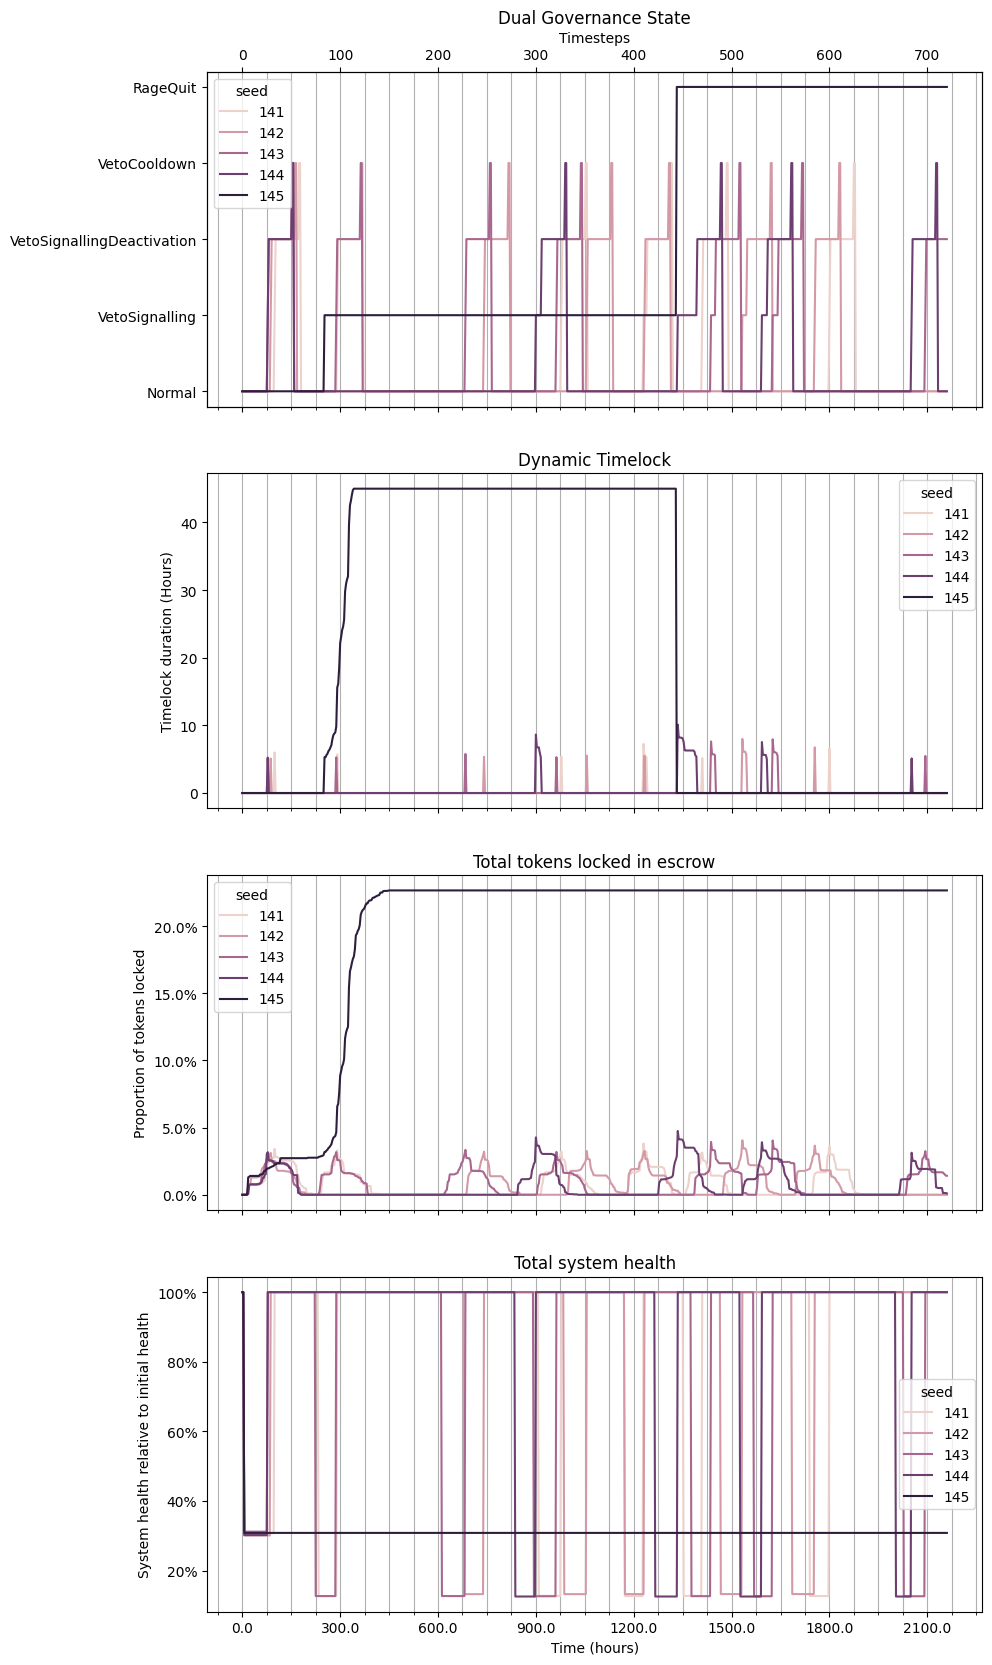

In [11]:
basesize = 5
n_plots = 4
fig, axes = plt.subplots(figsize=(basesize * 2, basesize * n_plots), nrows=n_plots, sharex=True)
sns.lineplot(result, x="timestep", y="dg_state_value", hue="seed", ax=axes[0])
state_names = {1: "Normal", 2: "VetoSignalling", 3: "VetoSignallingDeactivation", 4: "VetoCooldown", 5: "RageQuit"}
axes[0].set_yticks(list(state_names.keys()), labels=list(state_names.values()))
axes[0].set_ylabel("")
axes[0].set_title("Dual Governance State")

sns.lineplot(result, x="timestep", y="dg_dynamic_timelock_hours", hue="seed", ax=axes[1])
axes[1].set_ylabel("Timelock duration (Hours)")
axes[1].set_title("Dynamic Timelock")

sns.lineplot(actors_df_summed_by_actors, x="timestep", y="total_coins_locked_relative", hue="seed", ax=axes[2])
axes[2].set_title("Total tokens locked in escrow")
axes[2].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0))
axes[2].set_ylabel("Proportion of tokens locked")

sns.lineplot(actors_df_summed_by_actors, x="timestep", y="health_relative", hue="seed", ax=axes[3])
axes[3].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0))
axes[3].set_title("Total system health")
axes[3].set_ylabel("System health relative to initial health")

axes[0].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{x * 3}"))
axes[0].xaxis.set_minor_locator(ticker.MultipleLocator(25))
axes[-1].set_xlabel("Time (hours)")

ax_twin = axes[0].twiny()
# ax2.grid(True)
ax_twin.set_xlabel("Timesteps")
ax_twin.set_xticks(axes[0].get_xticks())
ax_twin.set_xlim(axes[0].get_xlim())
for i in range(len(axes)):
    axes[i].grid(True, axis="x", which="both")

fig.savefig(simulation_path.joinpath("Lock dynamics" + ".png"), dpi=300)
fig.savefig(simulation_path.joinpath("Lock dynamics" + ".svg"), dpi=1000)

#### Individual plots


In [12]:
for seed in result.seed.unique():
    basesize = 5
    n_plots = 4
    fig, axes = plt.subplots(figsize=(basesize * 2, basesize * n_plots), nrows=n_plots, sharex=True)
    sns.lineplot(result[result["seed"] == seed], x="timestep", y="dg_state_value", ax=axes[0])
    state_names = {1: "Normal", 2: "VetoSignalling", 3: "VetoSignallingDeactivation", 4: "VetoCooldown", 5: "RageQuit"}
    axes[0].set_yticks(list(state_names.keys()), labels=list(state_names.values()))
    axes[0].set_ylabel("")
    axes[0].set_title("Dual Governance State")

    sns.lineplot(result[result["seed"] == seed], x="timestep", y="dg_dynamic_timelock_hours", ax=axes[1])
    axes[1].set_ylabel("Timelock duration (Hours)")
    axes[1].set_title("Dynamic Timelock")

    sns.lineplot(
        actors_df_summed_by_actors[actors_df_summed_by_actors["seed"] == seed],
        x="timestep",
        y="total_coins_locked_relative",
        ax=axes[2],
    )
    axes[2].set_title("Total tokens locked in escrow")
    axes[2].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0))
    axes[2].set_ylabel("Proportion of tokens locked")
    axes[2].yaxis.set_minor_locator(ticker.MultipleLocator(0.01))
    axes[2].grid(True, axis="y", which="both")

    sns.lineplot(
        actors_df_summed_by_actors[actors_df_summed_by_actors["seed"] == seed],
        x="timestep",
        y="health_relative",
        ax=axes[3],
    )
    axes[3].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0))
    axes[3].set_title("Total system health")
    axes[3].set_ylabel("System health relative to initial health")

    ### proposals
    simulation_start = (
        result[(result["seed"] == seed) & (result["timestep"] == 0)]
        .time_manager.apply(lambda tm: tm.current_time)
        .iloc[0]
        .timestamp()
    )
    proposals_info = (
        result[result["seed"] == seed].dual_governance.apply(lambda dg: dg.timelock.proposals.state.proposals).iloc[-1]
    )
    proposal_dict = defaultdict(list)
    for proposal in proposals_info:
        proposal_dict["id"].append(proposal.id)
        proposal_dict["status"].append(proposal.status)
        proposal_dict["submittedAt"].append((proposal.submittedAt.to_seconds() - simulation_start) / 3600 / 3)
        proposal_dict["scheduledAt"].append((proposal.scheduledAt.to_seconds() - simulation_start) / 3600 / 3)
        proposal_dict["executedAt"].append((proposal.executedAt.to_seconds() - simulation_start) / 3600 / 3)
    proposal_df = pd.DataFrame(proposal_dict).set_index("id")
    for i in range(n_plots):
        for proposal_id in proposal_df.index:
            prop = proposal_df.loc[proposal_id]
            ylim = axes[i].get_ylim()
            dy = (ylim[1] - ylim[0]) * 0.1
            axes[i].plot(np.repeat(prop.submittedAt, 2), [ylim[0], ylim[0] + dy], color="orange")
            axes[i].set_ylim(ylim)
        axes[i].plot([], [], color="orange", label="Proposal submittion")
        axes[i].legend()
    ### proposals

    axes[0].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{x * 3}"))
    axes[0].xaxis.set_minor_locator(ticker.MultipleLocator(25))
    axes[-1].set_xlabel("Time (hours)")

    ax_twin = axes[0].twiny()
    # ax2.grid(True)
    ax_twin.set_xlabel("Timesteps")
    ax_twin.set_xticks(axes[0].get_xticks())
    ax_twin.set_xlim(axes[0].get_xlim())
    for i in range(len(axes)):
        axes[i].grid(True, axis="x", which="both")

    fig.savefig(simulation_path.joinpath(f"Lock dynamics (seed={seed})" + ".png"), dpi=300)
    fig.savefig(simulation_path.joinpath(f"Lock dynamics (seed={seed})" + ".svg"), dpi=1000)
    plt.close(fig)

#### Individual plots broken down by ReactionTime (unfinished)


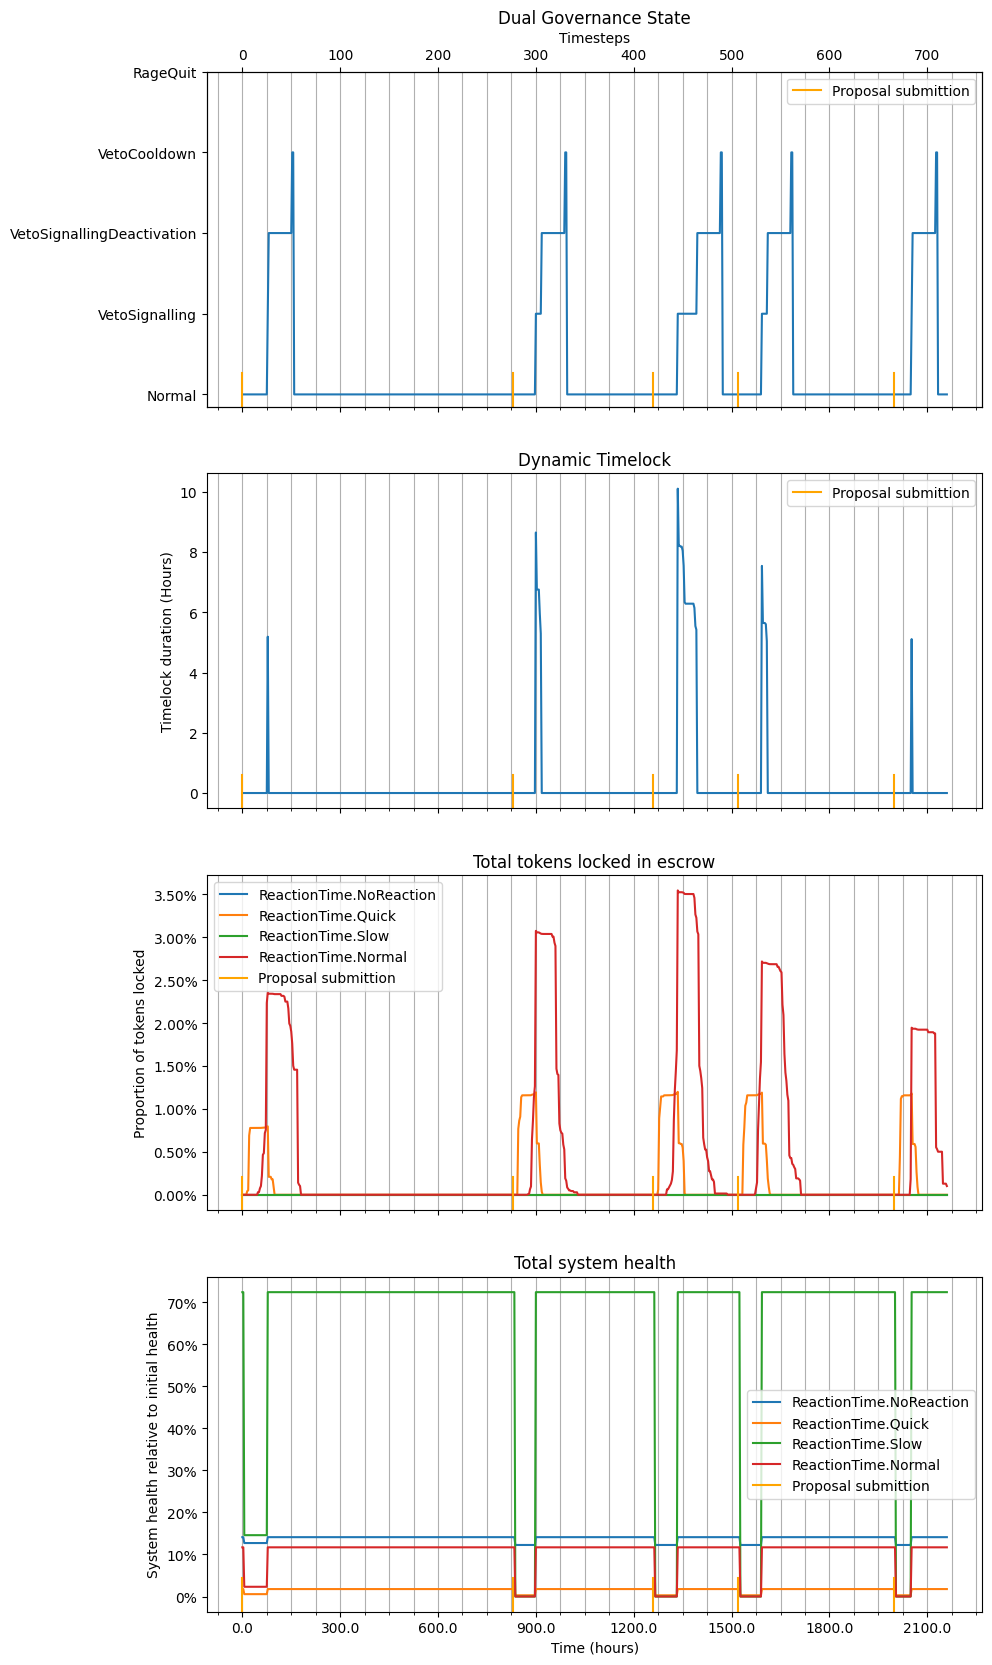

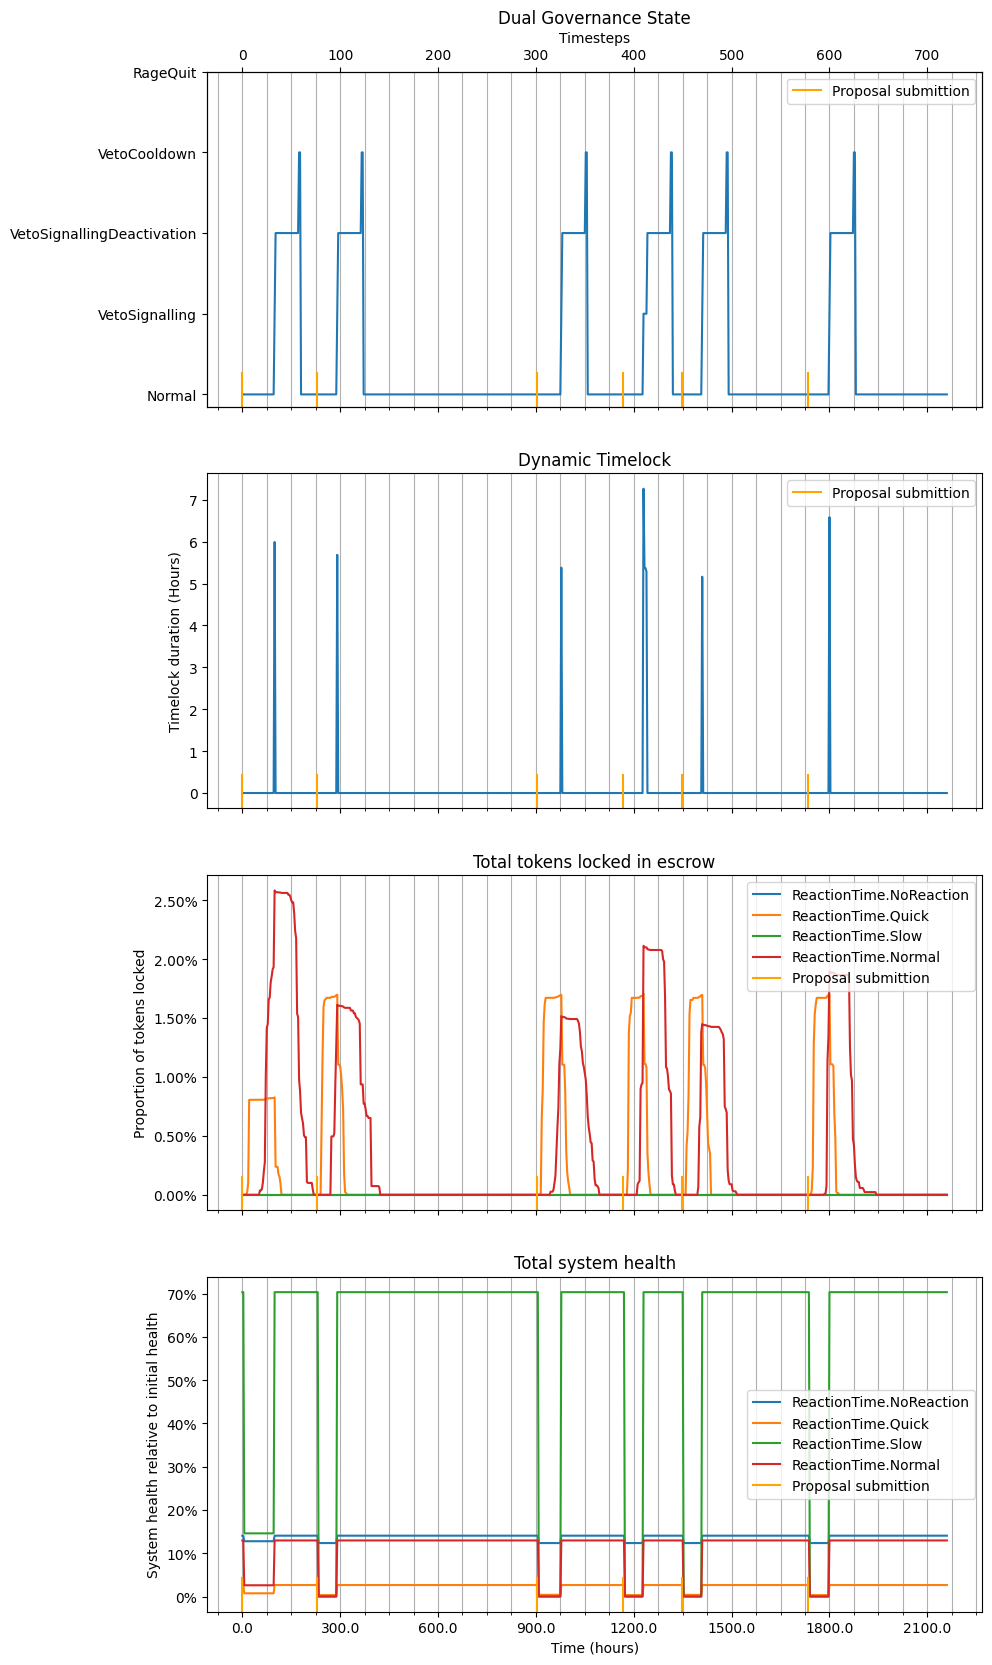

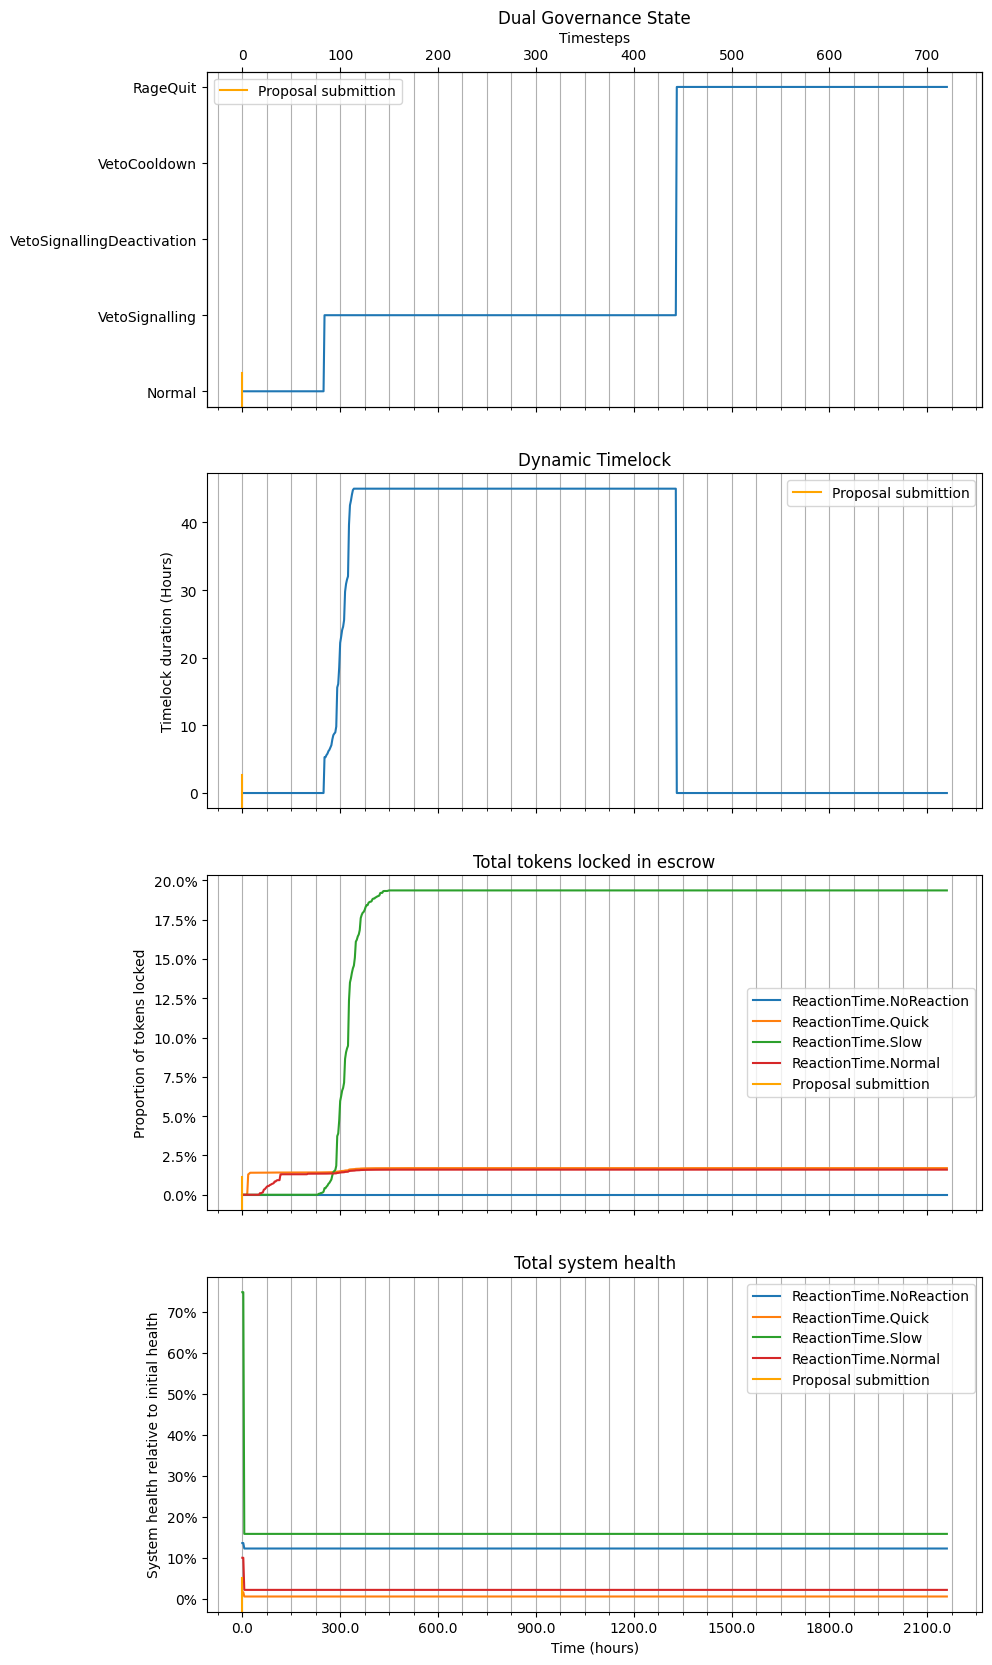

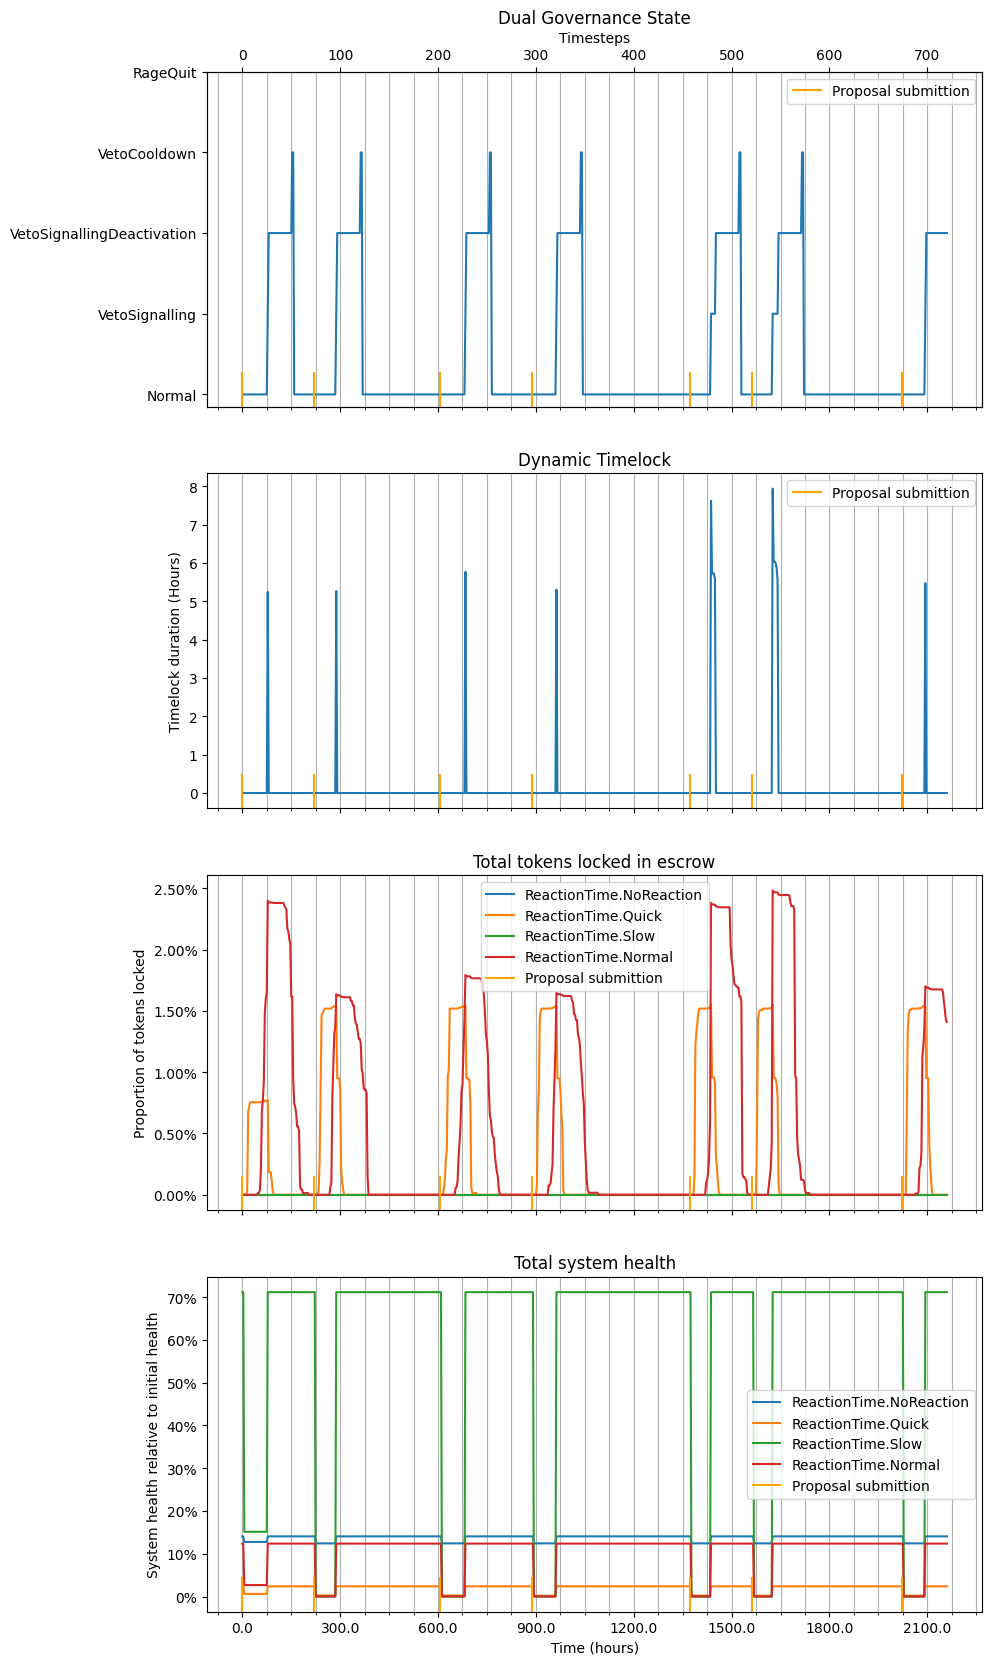

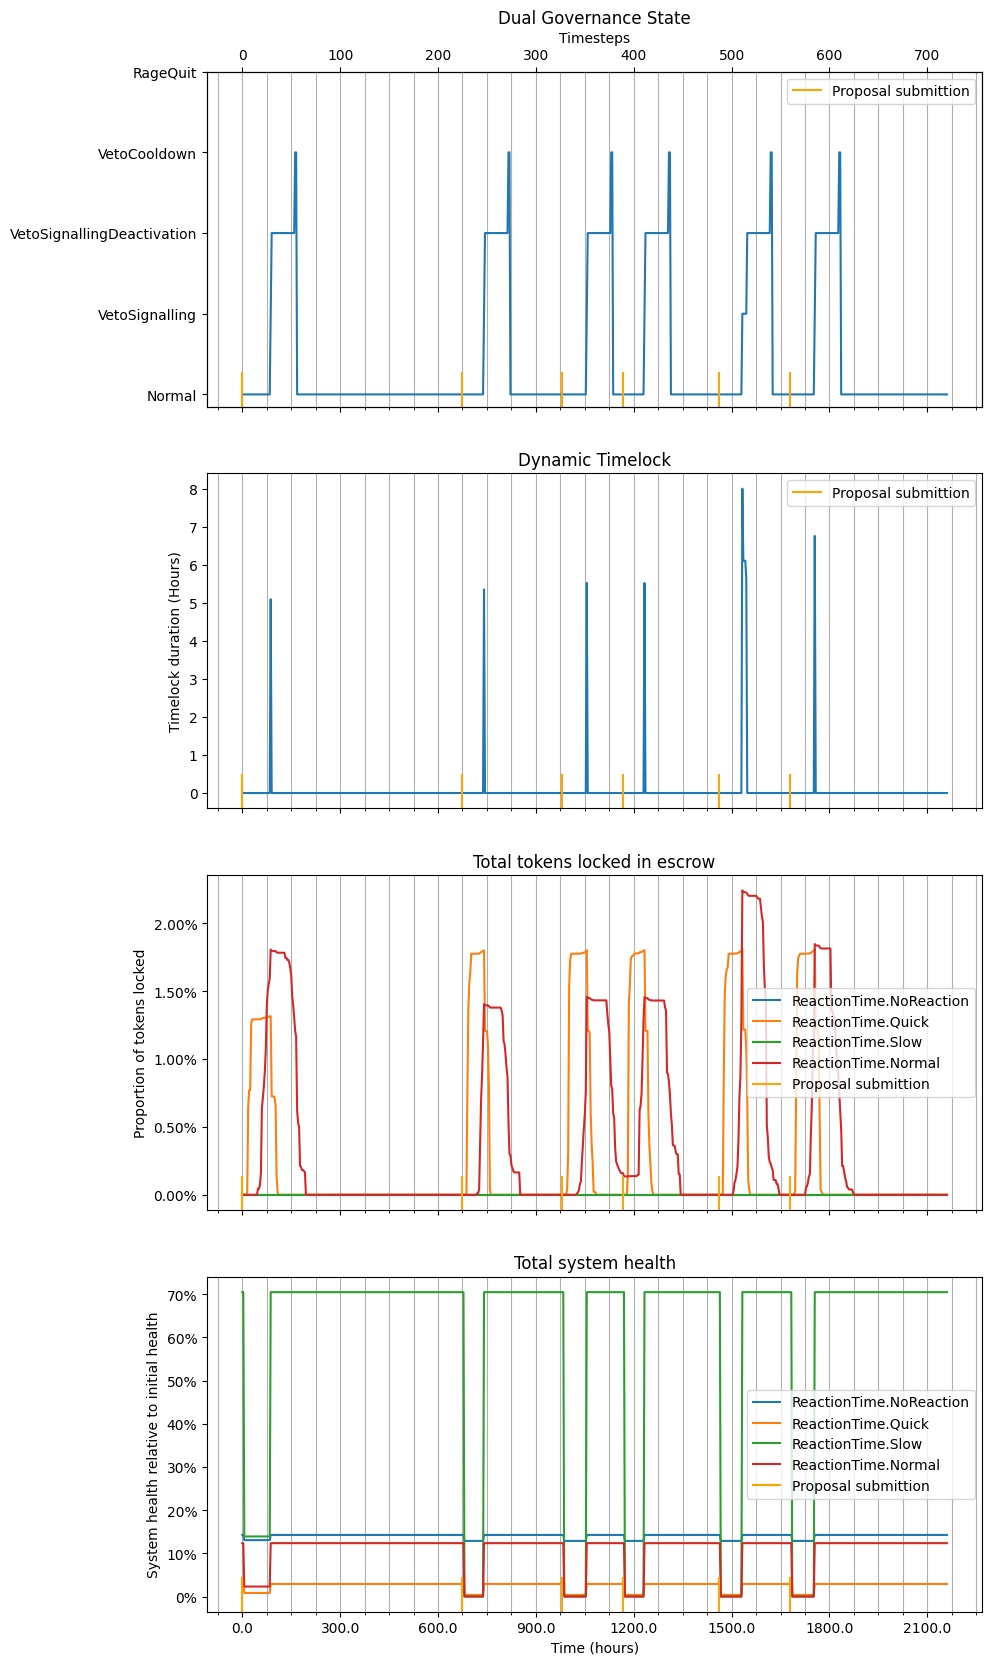

In [13]:
for seed in result.seed.unique():
    basesize = 5
    n_plots = 4
    fig, axes = plt.subplots(figsize=(basesize * 2, basesize * n_plots), nrows=n_plots, sharex=True)
    sns.lineplot(result[result["seed"] == seed], x="timestep", y="dg_state_value", ax=axes[0])
    state_names = {1: "Normal", 2: "VetoSignalling", 3: "VetoSignallingDeactivation", 4: "VetoCooldown", 5: "RageQuit"}
    axes[0].set_yticks(list(state_names.keys()), labels=list(state_names.values()))
    axes[0].set_ylabel("")
    axes[0].set_title("Dual Governance State")

    sns.lineplot(result[result["seed"] == seed], x="timestep", y="dg_dynamic_timelock_hours", ax=axes[1])
    axes[1].set_ylabel("Timelock duration (Hours)")
    axes[1].set_title("Dynamic Timelock")

    sns.lineplot(
        actors_df_summed_by_actors_rts[actors_df_summed_by_actors_rts["seed"] == seed],
        x="timestep",
        y="total_coins_locked_relative",
        hue="reaction_time",
        ax=axes[2],
    )
    axes[2].set_title("Total tokens locked in escrow")
    axes[2].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0))
    axes[2].set_ylabel("Proportion of tokens locked")

    sns.lineplot(
        actors_df_summed_by_actors_rts[actors_df_summed_by_actors_rts["seed"] == seed],
        x="timestep",
        y="health_relative",
        hue="reaction_time",
        ax=axes[3],
    )
    axes[3].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0))
    axes[3].set_title("Total system health")
    axes[3].set_ylabel("System health relative to initial health")

    ### proposals
    simulation_start = (
        result[(result["seed"] == seed) & (result["timestep"] == 0)]
        .time_manager.apply(lambda tm: tm.current_time)
        .iloc[0]
        .timestamp()
    )
    proposals_info = (
        result[result["seed"] == seed].dual_governance.apply(lambda dg: dg.timelock.proposals.state.proposals).iloc[-1]
    )
    proposal_dict = defaultdict(list)
    for proposal in proposals_info:
        proposal_dict["id"].append(proposal.id)
        proposal_dict["status"].append(proposal.status)
        proposal_dict["submittedAt"].append((proposal.submittedAt.to_seconds() - simulation_start) / 3600 / 3)
        proposal_dict["scheduledAt"].append((proposal.scheduledAt.to_seconds() - simulation_start) / 3600 / 3)
        proposal_dict["executedAt"].append((proposal.executedAt.to_seconds() - simulation_start) / 3600 / 3)
    proposal_df = pd.DataFrame(proposal_dict).set_index("id")
    for i in range(n_plots):
        for proposal_id in proposal_df.index:
            prop = proposal_df.loc[proposal_id]
            ylim = axes[i].get_ylim()
            dy = (ylim[1] - ylim[0]) * 0.1
            axes[i].plot(np.repeat(prop.submittedAt, 2), [ylim[0], ylim[0] + dy], color="orange")
            axes[i].set_ylim(ylim)
        axes[i].plot([], [], color="orange", label="Proposal submittion")
        axes[i].legend()
    ### proposals

    axes[0].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{x * 3}"))
    axes[0].xaxis.set_minor_locator(ticker.MultipleLocator(25))
    axes[-1].set_xlabel("Time (hours)")

    ax_twin = axes[0].twiny()
    # ax2.grid(True)
    ax_twin.set_xlabel("Timesteps")
    ax_twin.set_xticks(axes[0].get_xticks())
    ax_twin.set_xlim(axes[0].get_xlim())
    for i in range(len(axes)):
        axes[i].grid(True, axis="x", which="both")

    fig.savefig(simulation_path.joinpath(f"Lock dynamics (seed={seed}) by ReactionTime" + ".png"), dpi=300)
    fig.savefig(simulation_path.joinpath(f"Lock dynamics (seed={seed}) by ReactionTime" + ".svg"), dpi=1000)
    plt.show()
    plt.close(fig)

### Analysis


In [14]:
start_idx = PRESENTED_RUN * (TIMESTEPS + (1 if PRESENTED_RUN > 0 else 0))
end_idx = start_idx + TIMESTEPS

submitted_proposals = post_processing.loc[end_idx, "proposals_submitted_count"]
canceled_proposals = post_processing.loc[end_idx, "proposals_canceled_count"]
proposals_damage = post_processing.loc[end_idx, "total_damage_of_proposals"]
average_damage = post_processing.loc[end_idx, "average_damage_per_proposal"]

display(Markdown(f"### Results summary for Monte Carlo Run {PRESENTED_RUN + 1}"))
display(Markdown(f"##### Submitted Proposals: **{submitted_proposals}**"))
display(Markdown(f"##### Canceled Proposals: **{canceled_proposals}**"))
display(Markdown(f"##### Total Damage of Proposals: **{proposals_damage}**"))
display(Markdown(f"##### Average Damage per Proposal: **{average_damage}**"))

### Results summary for Monte Carlo Run 1

##### Submitted Proposals: **6**

##### Canceled Proposals: **6**

##### Total Damage of Proposals: **545**

##### Average Damage per Proposal: **90.83333333333331**

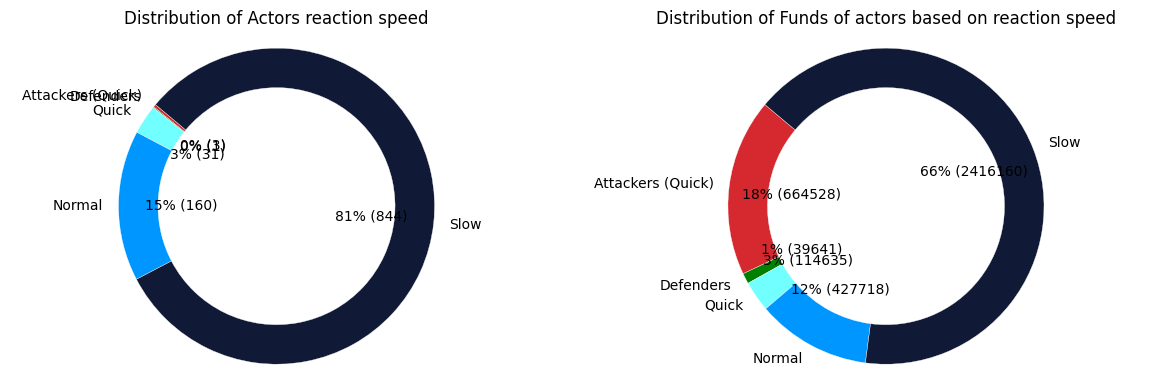

In [15]:
post_processing["total_quick_honest_actors_reaction_time"] = (
    post_processing["total_quick_actors_reaction_time"] - post_processing["total_attackers"]
)
post_processing["total_quick_honest_actors_funds"] = (
    post_processing["total_quick_actors_funds"] - post_processing["total_attackers_actors_funds"]
)


def generate_distribution(post_processing, labels, columns, colors, title):
    filtered_labels = []
    filtered_columns = []
    filtered_colors = []

    for label, column, color in zip(labels, columns, colors):
        value = post_processing[column]
        if (value != 0).any():
            filtered_labels.append(label)
            filtered_columns.append(column)
            filtered_colors.append(color)

    return (filtered_labels, filtered_columns, filtered_colors, title)


actors_distribution = generate_distribution(
    post_processing,
    ["Attackers (Quick)", "Defenders", "Quick", "Normal", "Slow"],
    [
        "total_attackers",
        "total_defenders",
        "total_quick_honest_actors_reaction_time",
        "total_normal_actors_reaction_time",
        "total_slow_actors_reaction_time",
    ],
    ["#D6292F", "green", "#72FFFF", "#0096FF", "#101A36"],
    "Distribution of Actors reaction speed",
)

funds_distribution = generate_distribution(
    post_processing,
    ["Attackers (Quick)", "Defenders", "Quick", "Normal", "Slow"],
    [
        "total_attackers_actors_funds",
        "total_defenders_actors_funds",
        "total_quick_honest_actors_funds",
        "total_normal_actors_funds",
        "total_slow_actors_funds",
    ],
    ["#D6292F", "green", "#72FFFF", "#0096FF", "#101A36"],
    "Distribution of Funds of actors based on reaction speed",
)

## add legend

fig = create_donut_charts_2(post_processing, [actors_distribution, funds_distribution], 1, TIMESTEPS)

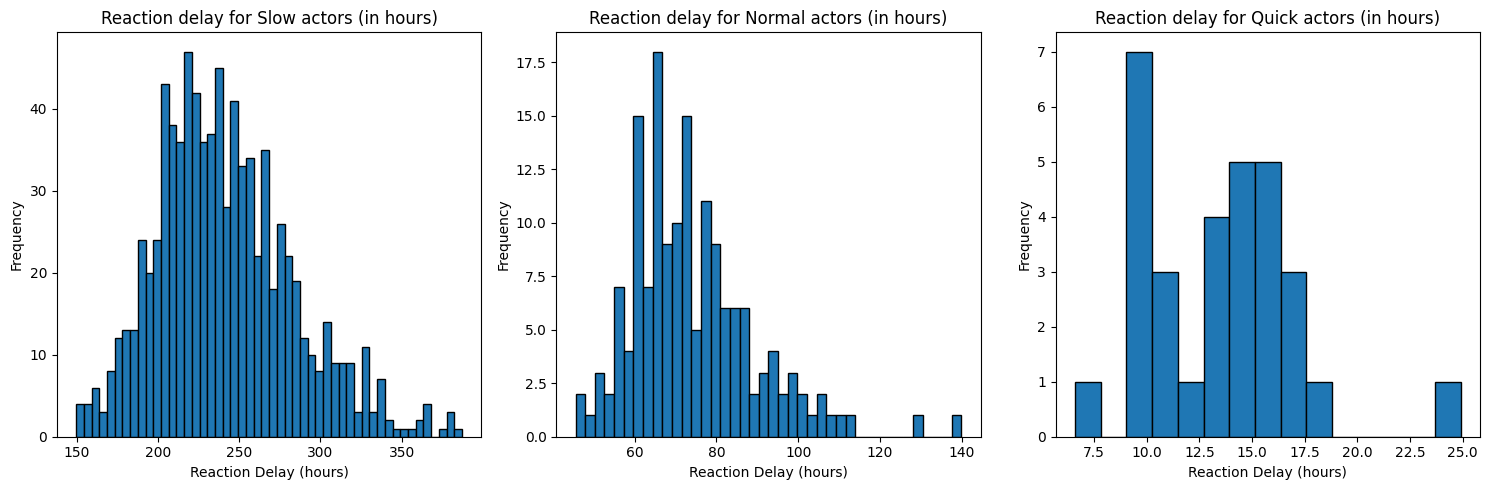

In [16]:
def plot_reaction_delay_histogram(actors_df, timestep, seed, reaction_times, time_unit, bins_list):
    actors_end = actors_df[(actors_df["timestep"] == timestep) & (actors_df["seed"] == seed)].copy()
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    for i, (reaction_time, bins) in enumerate(zip(reaction_times, bins_list)):
        reaction_delay_series = actors_end.loc[
            actors_end["reaction_time"] == "ReactionTime." + str(reaction_time), "reaction_delay"
        ]

        reaction_delay_series = reaction_delay_series[reaction_delay_series != 9223372036854775807]

        if time_unit == "hours":
            reaction_delay_series_converted = reaction_delay_series / 3600
            xlabel = "Reaction Delay (hours)"
            title = f"Reaction delay for {reaction_time} actors (in hours)"
        elif time_unit == "days":
            reaction_delay_series_converted = reaction_delay_series / (3600 * 24)
            xlabel = "Reaction Delay (days)"
            title = f"Reaction delay for {reaction_time} actors (in days)"
        else:
            raise ValueError("Invalid time unit. Use 'hours' or 'days'.")

        reaction_delay_series_converted.plot(kind="hist", bins=bins, edgecolor="black", ax=axes[i])
        axes[i].set_xlabel(xlabel)
        axes[i].set_ylabel("Frequency")
        axes[i].set_title(title)

    plt.tight_layout()
    plt.show()


plot_reaction_delay_histogram(actors_df, TIMESTEPS, SEED, ["Slow", "Normal", "Quick"], "hours", [50, 40, 15])

## add explanation about the distributions

#### Results Summary for Run 1

##### Time from maximum total health to maximum combined_percentage_locked: **1230 hours** (51.25 days)

##### Maximum percentage of rage quit support : **3.68 %**

##### Maximum number of locked tokens : **216202.34 stETH** and **61626.35 wstETH**

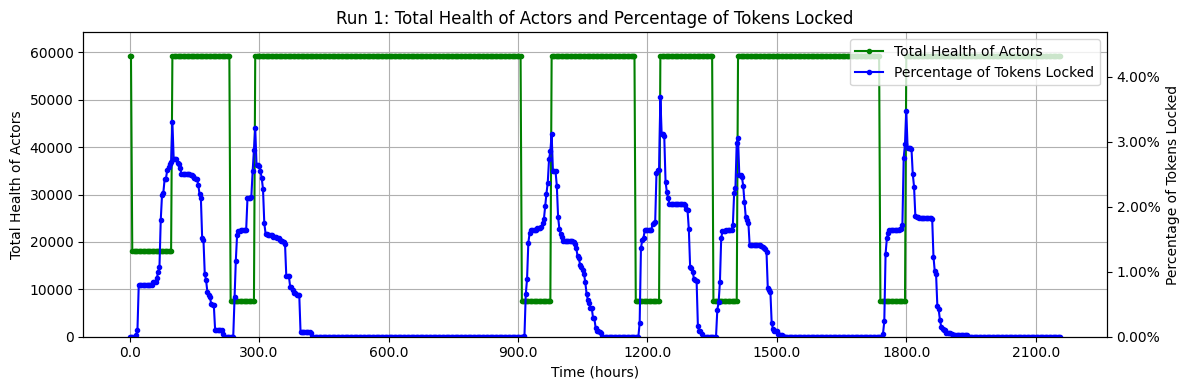

In [17]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from IPython.display import Markdown, display

start_idx = PRESENTED_RUN * (TIMESTEPS + (1 if PRESENTED_RUN > 0 else 0))
end_idx = start_idx + TIMESTEPS

total_stETH_balance = post_processing["total_stETH_balance"].iloc[start_idx:end_idx]
total_stETH_locked = post_processing["total_stETH_locked"].iloc[start_idx:end_idx]
total_wstETH_balance = post_processing["total_wstETH_balance"].iloc[start_idx:end_idx]
total_wstETH_locked = post_processing["total_wstETH_locked"].iloc[start_idx:end_idx]
total_actors_damaged = post_processing["total_actors_damaged"].iloc[start_idx:end_idx]
total_actors_health = post_processing["total_actors_health"].iloc[start_idx:end_idx]
total_actors_recovery = post_processing["total_actors_recovery"].iloc[start_idx:end_idx]
rage_quit_support = post_processing["rage_quit_support"].iloc[start_idx:end_idx]
timesteps = post_processing["timestep"].iloc[start_idx:end_idx]

combined_balance = total_stETH_balance + total_wstETH_balance + total_stETH_locked + total_wstETH_locked
combined_locked = total_stETH_locked + total_wstETH_locked

percentage_locked = [
    (locked / balance) if balance != 0 else 0 for locked, balance in zip(combined_locked, combined_balance)
]

max_total_health_idx = total_actors_health.idxmax()
max_total_health_ts = timesteps[max_total_health_idx]

max_combined_percentage_locked_idx = percentage_locked.index(max(percentage_locked))
max_combined_percentage_locked_ts = timesteps[start_idx + max_combined_percentage_locked_idx]

time_difference = max_combined_percentage_locked_ts - max_total_health_ts
time_difference_hours = time_difference * 3
time_difference_days = time_difference_hours / 24

display(Markdown(f"#### Results Summary for Run {PRESENTED_RUN + 1}"))
display(
    Markdown(
        f"##### Time from maximum total health to maximum combined_percentage_locked: **{time_difference_hours} hours** ({time_difference_days:.2f} days)"
    )
)
display(Markdown(f"##### Maximum percentage of rage quit support : **{rage_quit_support.max():.2f} %**"))
display(
    Markdown(
        f"##### Maximum number of locked tokens : **{total_stETH_locked.max():.2f} stETH** and **{total_wstETH_locked.max():.2f} wstETH**"
    )
)

fig, ax1 = plt.subplots(figsize=(12, 4))

# Plot total_actors_health on the left y-axis
ax1.plot(timesteps, total_actors_health, color="green", label="Total Health of Actors", marker="o", markersize=3)
max_total_health = total_actors_health.max()
max_total_health_rounded = max_total_health + 5000

ax1.set_xlabel("Time (hours)")
ax1.set_ylabel("Total Health of Actors")
ax1.set_ylim(0, max_total_health_rounded)  # Set y-axis limit based on maximum health
ax1.yaxis.set_major_formatter(ticker.ScalarFormatter())

# Create a secondary y-axis for percentage_locked
ax2 = ax1.twinx()
ax2.plot(timesteps, percentage_locked, color="blue", label="Percentage of Tokens Locked", marker="o", markersize=3)
ax2.set_ylabel("Percentage of Tokens Locked")

# Calculate the maximum value of percentage_locked and set the y-axis limit
max_percentage_locked = max(percentage_locked)
max_percentage_locked_rounded = max_percentage_locked + 0.01
ax2.set_ylim(0, max_percentage_locked_rounded)
ax2.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0))

# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc="upper right")

ax1.set_title(f"Run {PRESENTED_RUN + 1}: Total Health of Actors and Percentage of Tokens Locked")
ax1.grid(True)
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{x * 3}"))

plt.tight_layout()
plt.show()

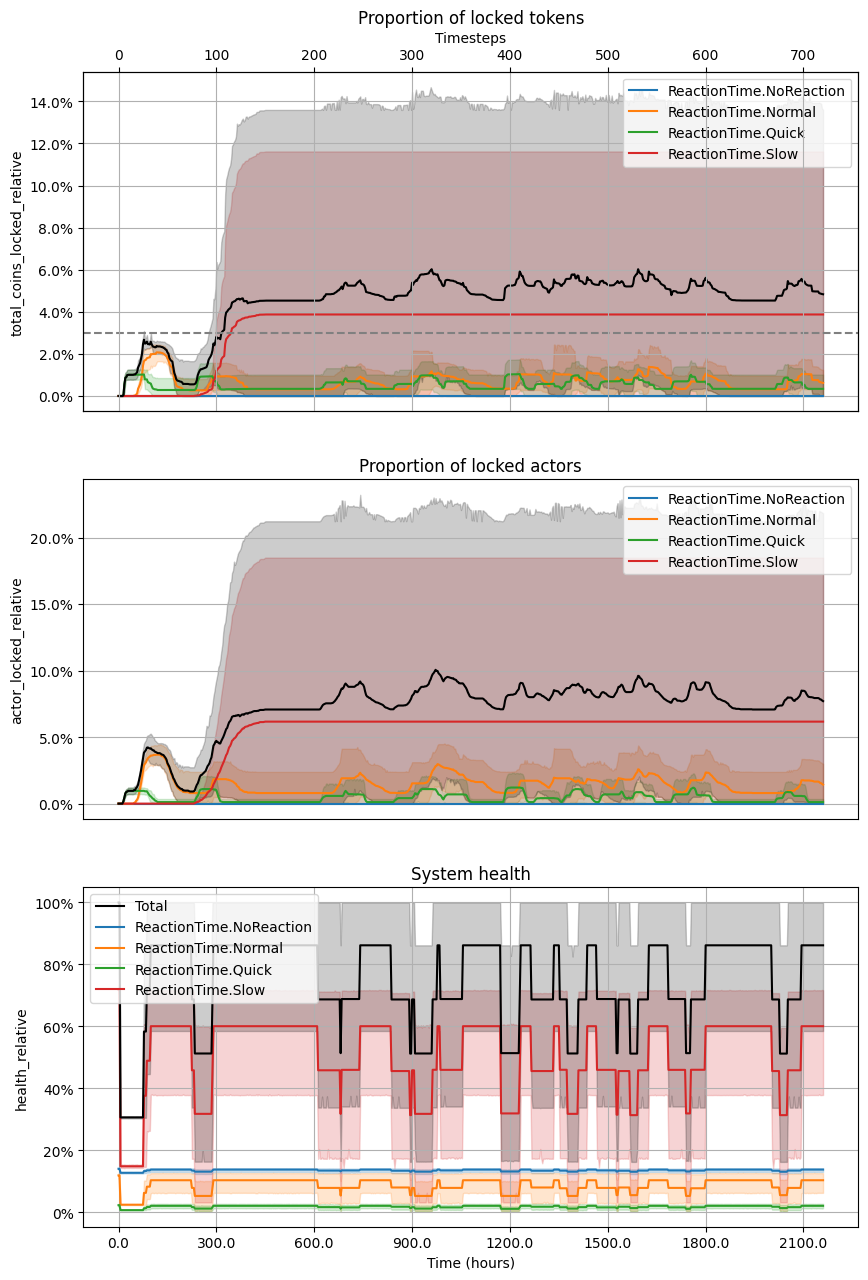

In [18]:
import seaborn as sns

ys = ("total_coins_locked_relative", "actor_locked_relative", "health_relative")
titles = ("Proportion of locked tokens", "Proportion of locked actors", "System health")

actors_df_summed_by_actors_rts = (
    actors_df.groupby(by=["seed", "timestep", "reaction_time"]).sum(numeric_only=True).reset_index()
)
actors_df_summed_by_actors = actors_df.groupby(by=["seed", "timestep"]).sum(numeric_only=True).reset_index()

basesize = 5
fig, axes = plt.subplots(figsize=(basesize * 2, basesize * len(ys)), nrows=len(ys), sharex=True)
for i, y in enumerate(ys):
    ax1 = axes[i]
    sns.lineplot(actors_df_summed_by_actors_rts, x="timestep", y=y, hue="reaction_time", ax=ax1)
    sns.lineplot(actors_df_summed_by_actors, x="timestep", y=y, ax=ax1, color="black")
    plt.plot([], [], color="black", label="Total")
    ax1.set_xlabel("Time (hours)")
    # ax1.set_ylim(0, 0.15)
    # ax1.set_xlim(0, 40)
    ax1.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0))
    ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{x * 3}"))

    if y == "total_coins_locked_relative":
        xlim = ax1.get_xlim()
        ax1.plot(xlim, [0.03, 0.03], linestyle="--", color="gray", label="Veto signalling threshold")
        ax1.set_xlim(xlim)

    if i == 0:
        ax2 = ax1.twiny()
        ax2.grid(True)
        ax2.set_xlabel("Timesteps")
        ax2.set_xticks(ax1.get_xticks())
        ax2.set_xlim(ax1.get_xlim())
    ax1.grid(True)
    if i != len(ys) - 1:
        ax1.get_xaxis().set_visible(False)

    title = titles[i]
    ax1.set_title(title)

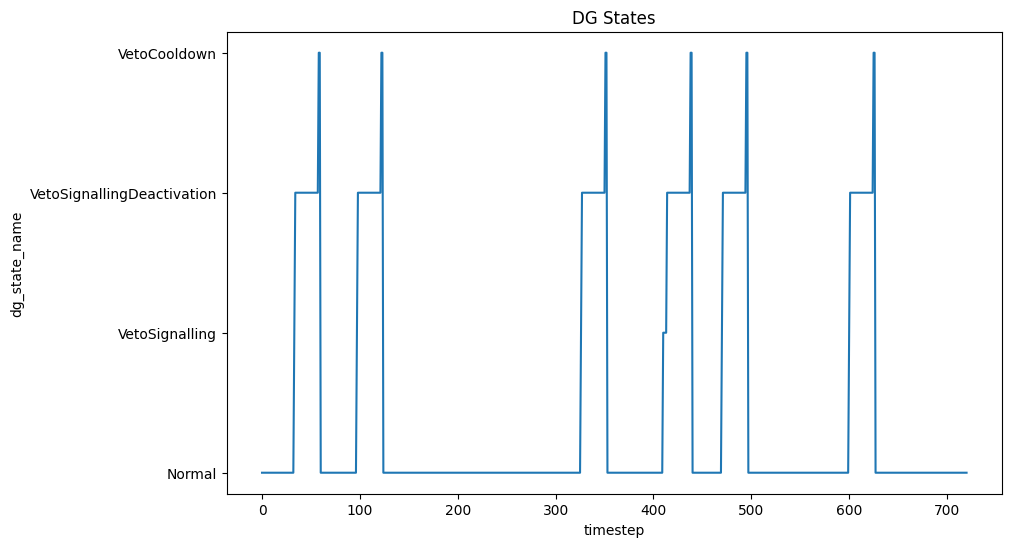

In [19]:
from specs.dual_governance.state import State

post_processing["dg_state_name"] = post_processing["dg_state"].apply(lambda x: x.replace("State.", ""))


def state_plot(df, x, y, run):
    states = df[df.simulation == run][y].map(lambda r: State[r].name)
    plt.figure(figsize=(10, 6))
    plt.plot(df[df.simulation == run][x], states)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title("DG States")
    plt.show()


state_plot(post_processing, "timestep", "dg_state_name", 1)